<a href="https://colab.research.google.com/github/tlmakinen/snapjax/blob/main/%5Bsimple_BayeSN%5D_snapjax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# snapjax intro

a quick walkthrough of an inference in Jax and Numpyro for Supernova Cosmology

In [1]:
!git clone https://github.com/tlmakinen/snapjax.git

Cloning into 'snapjax'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 116 (delta 40), reused 47 (delta 13), pack-reused 0
Receiving objects: 100% (116/116), 739.46 KiB | 4.35 MiB/s, done.
Resolving deltas: 100% (40/40), done.


In [2]:
!cp ./snapjax/data/jla_lcparams.txt .
!cp ./snapjax/data/sn1a_generator.py .

In [3]:
!pip install -q numpyro
!pip install -q corner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.6/304.6 kB 13.6 MB/s eta 0:00:00


In [4]:
!pip install -q jax-cosmo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


## generate some SNIa from JLA seed data
here we've simulated $N=250$ SNIa, so sampling will take a bit longer. $N=50$ is quick enough for debugging.

In [5]:
!python ./sn1a_generator.py 0.00 0.00 lc_params.txt sim_statssys.txt kde 50

simulating 50 SNe
Dipole Value:  0.00
Quadrupole Value:  0.00
LC Params filename:  lc_params.txt
Full Covariance filename:  sim_statssys.txt
Distribution on sky:  kde
-55.207462 359.63509 -66.485085 79.03174


In [6]:
import jax.numpy as np
from jax import grad, jit, vmap
from jax import random
import torch
import jax
from jax import lax
import jax_cosmo as jc
import scipy.constants as cnst

import matplotlib.pyplot as plt

In [7]:
inference_type = 'w'

# define auto-differentiable cosmology functions in `jax-cosmo`

In [8]:
# the integrand in the calculation of mu from z,cosmology
@jit
def integrand(zba, omegam, omegade, w):
    return 1.0/np.sqrt(
        omegam*(1+zba)**3 + omegade*(1+zba)**(3.+3.*w) + (1.-omegam-omegade)*(1.+zba)**2
    )

# integration of the integrand given above, vmapped over z-axis
@jit
def hubble(z,omegam, omegade,w):
    # method for calculating the integral
    myfun = lambda z: jc.scipy.integrate.romb(integrand,0., z, args=(omegam,omegade,w)) #[0]
    I = jax.vmap(myfun)(z)
    return I


@jit
def Dlz(omegam, omegade, h, z, w, z_helio):

    # which inference are we doing ?
    if inference_type == "omegade":
      omegakmag =  np.sqrt(np.abs(1-omegam-omegade))  
    else:
      omegakmag = 0.

    hubbleint = hubble(z,omegam,omegade,w)
    condition1 = (omegam + omegade == 1) # return True if = 1 
    condition2 = (omegam + omegade > 1.)

    #if (omegam+omegade)>1:
    def ifbigger(omegakmag):
      return (cnst.c*1e-5 *(1+z_helio)/(h*omegakmag)) * np.sin(hubbleint*omegakmag)

    # if (omegam+omegade)<1:
    def ifsmaller(omegakmag):
      return cnst.c*1e-5 *(1+z_helio)/(h*omegakmag) *np.sinh(hubbleint*omegakmag)   

    # if (omegam+omegade==1):
    def equalfun(omegakmag):
      return cnst.c*1e-5 *(1+z_helio)* hubbleint/h

    # if not equal, default to >1 condition
    def notequalfun(omegakmag):
      return lax.cond(condition2, true_fun=ifbigger, false_fun=ifsmaller, operand=omegakmag)

    distance = lax.cond(condition1, true_fun=equalfun, false_fun=notequalfun, operand=omegakmag)

    return distance


# muz: distance modulus as function of params, redshift
@jit
def muz(omegam, w, z):
    z_helio = z # should this be different ?
    omegade = 1. - omegam
    #w = -1.0 # freeze w
    h = 0.72
    return (5.0 * np.log10(Dlz(omegam, omegade, h, z, w, z_helio))+25.)

# plot $mu(z)$ at fiducial model

time to compute 500 SNIa distance integrals:
CPU times: user 2.04 s, sys: 132 ms, total: 2.18 s
Wall time: 1.55 s


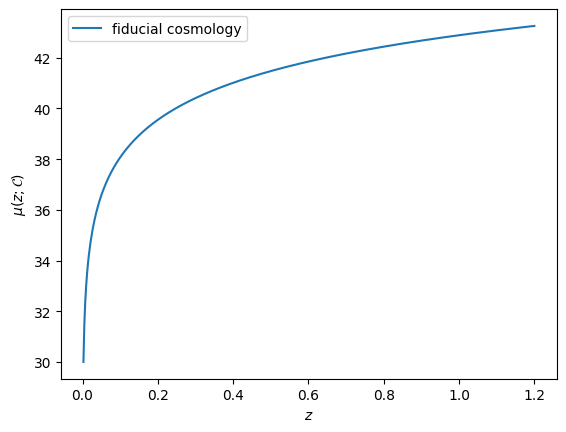

In [9]:
zs = np.linspace(0, 1.2, num=500)
print('time to compute 500 SNIa distance integrals:')
%time mymus = muz(0.3, 0.7, zs)
plt.plot(zs, mymus, label='fiducial cosmology')

plt.xlabel(r'$z$')
plt.ylabel(r'$\mu(z; \mathcal{C})$')
plt.legend()
plt.show()

# build our sampler

In [10]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, HMC

In [11]:
@jit
def log_uniform(r, log_min_val, log_max_val):
    """log-uniform prior
      given point sampled from unif(0, 1)
      return point sampled on a uniform log scale from min_val to max_val
      """
    #log_min_val = np.log10(min_val)
    #log_max_val = np.log10(max_val)
    point = 10.0 ** (log_min_val + r * (log_max_val - log_min_val))

    return point

### the bahamas model with Simple BayeSN

here we modify vanilla BAHAMAS to incorporate dust effects in the colour parameter distribution

In [12]:
## define bahamas HMC model
def bahamas(z, data, Cov, snID, ndat):

    # globals
    OmM = numpyro.sample('OmM', dist.Uniform(low=0.0, high=1.0))
    w = numpyro.sample('w', dist.Uniform(low=-2.0, high=0.0))
    #OmDE = numpyro.sample('OmDE', dist.Uniform(low=0.0, high=2.0)) # for OmDE inference

    α = numpyro.sample('α', dist.Uniform(0.0, 1.0))
    β = numpyro.sample('β', dist.Uniform(0.0, 4.0))

    R_B = numpyro.sample('R_B', dist.Uniform(0.0, 5.0)) # should equal β in toy example


    # mB hypers
    #σ_res =  numpyro.sample('σ_res', dist.TransformedDistribution(
    #                  dist.Uniform(-3.0, 0.0), 
    #                  dist.transforms.ExpTransform()))
    σ_res_sq = numpyro.sample('σ_res_sq', dist.InverseGamma(0.003, 0.003))

    σ_res = np.sqrt(σ_res_sq)

    M0 = numpyro.sample('M0', dist.Normal(-19.3, 2.0))
    # stretch hypers
    xstar = numpyro.sample('xstar', dist.Normal(loc=0.0,scale=0.1))
    #_rx = numpyro.sample('_rx', dist.Uniform())
    #Rx =  log_uniform(_rx, -5.0, 2.0)
    Rx =  numpyro.sample('Rx', dist.TransformedDistribution(
                      dist.Uniform(-5.0, 2.0), 
                      dist.transforms.ExpTransform()))


    # color hypers
    cstar = numpyro.sample('cstar', dist.Normal(loc=0.0,scale=0.1))
    #_rc = numpyro.sample('Rc', dist.Uniform())
    #Rc = log_uniform(_rc, -5.0, 2.0)

    Rc = numpyro.sample('Rc', dist.TransformedDistribution(
                      dist.Uniform(-5.0, 2.0), 
                      dist.transforms.ExpTransform()))
    
    # SIMPLE BAYESN PARAMETERS
    τ = numpyro.sample("τ", dist.Uniform(0.0, 10.0)) # for dust

    unique_sn_IDs = snID
    n_sne = len(unique_sn_IDs)

    # now latents

    with numpyro.plate("plate_i", n_sne) as idx:
        c_ = numpyro.sample('c', dist.Normal(cstar, Rc))
        x1_ = numpyro.sample('x1', dist.Normal(xstar, Rx))
        M_ = numpyro.sample('M', dist.Normal(M0, σ_res))
        E_ = numpyro.sample('E_', dist.Exponential(rate=1./τ))



   # myM = -(muz(true_omegam, true_w, z) - true_alpha*datadf["x1"] + true_beta*datadf["c"]) + datadf['mb']
   # datadf['mb'] = + muz + alpha*x1 - beta*c + M

    # compute mB [IMPORTANT BIT]
    mB_ = muz(OmM, w, z[snID]) - α*x1_[snID] + β*c_[snID] + M_[snID] + (R_B - β)*E_[snID]


    # assemble means for obs variable draw
    _obsloc = np.stack((c_,x1_,mB_), axis=1)

    # now sample observed values with measured covariance
    with numpyro.plate("plate_i", n_sne): #as idx:
        numpyro.sample('obs', dist.MultivariateNormal(_obsloc, Cov), obs=data)


In [13]:
import pandas as pd
import numpy as onp


datafname = 'lc_params.txt'

# load data 

names = ['z', 'c', 'x1', 'mb']
datadf = pd.read_csv(datafname, header=0, sep='\s+', usecols=names)
z = datadf['z'].values
data = np.array(datadf[['c', 'x1', 'mb']])
ndat = len(data)

# unpack block diags
sigmaC = onp.array(onp.loadtxt('sim_statssys.txt'))
M = int(3)
covs = np.array([sigmaC[i*M:(i+1)*M,i*M:(i+1)*M] for i in range(sigmaC.shape[0]//M)])

errors = onp.zeros((data.shape[0], 3))
for i in range(data.shape[0]):
  errors[i, :] = onp.diag(covs[i])

datadf['dc'] = errors[:, 0]
datadf['dx1'] = errors[:, 1]
datadf['dmb'] = errors[:, 2]

ID = np.arange(ndat)

In [34]:
datadf.shape

(50, 7)

In [35]:
np.save('bhm_data', np.array([datadf[['z', 'mb', 'dmb', 'x1', 'dx1', 'c', 'dc']]]))

In [36]:
data.shape

(50, 3)

CPU times: user 1.98 s, sys: 26.5 ms, total: 2 s
Wall time: 1.23 s


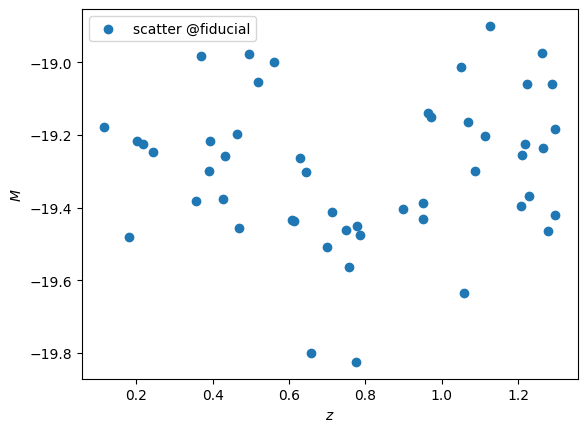

In [14]:
# plot truth just to be sure
true_alpha = 0.13
true_beta = 2.56
true_omegam = 0.3
true_w = -1.0

zs = np.linspace(0, 1.2, num=500)
%time myM = -(muz(true_omegam, true_w, z) - true_alpha*datadf["x1"] + true_beta*datadf["c"]) + datadf['mb']
plt.scatter(z, myM, label='scatter @fiducial')

plt.xlabel(r'$z$')
plt.ylabel(r'$M$')
plt.legend()
plt.show()

## run sampler

In [ ]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
kernel = NUTS(bahamas, target_accept_prob=0.9)

mcmc = MCMC(kernel, num_warmup=1000, num_samples=500)
mcmc.run(rng_key_, z=z, data=data, Cov=covs, snID=ID, ndat=ndat)
mcmc.print_summary()

In [23]:
rng_key = random.PRNGKey(100)
rng_key, rng_key_ = random.split(rng_key)
kernel = NUTS(bahamas, target_accept_prob=0.9)

mcmc = MCMC(kernel, num_warmup=1100, num_samples=800)
mcmc.run(rng_key_, z=z, data=data, Cov=covs, snID=ID, ndat=ndat)
mcmc.print_summary()

sample: 100%|██████████| 1900/1900 [49:30<00:00,  1.56s/it, 511 steps of size 6.86e-03. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     E_[0]      0.75      1.83      0.11      0.00      1.87     61.22      1.02
     E_[1]      1.00      3.16      0.11      0.00      2.13     45.41      1.03
     E_[2]      0.69      1.53      0.10      0.00      2.26     44.19      1.01
     E_[3]      0.63      1.27      0.11      0.00      2.01     47.71      1.02
     E_[4]      0.68      1.70      0.10      0.00      1.88     58.65      1.03
     E_[5]      0.65      1.40      0.10      0.00      1.90     40.26      1.02
     E_[6]      0.69      1.60      0.10      0.00      2.05     45.00      1.02
     E_[7]      0.70      1.55      0.10      0.00      2.25     50.90      1.03
     E_[8]      0.71      1.73      0.09      0.00      1.90     67.50      1.02
     E_[9]      0.76      1.70      0.10      0.00      2.37     49.76      1.02
    E_[10]      0.73      1.68      0.10      0.00      2.27     49.33      1.01
    E_[11]      0.80      2

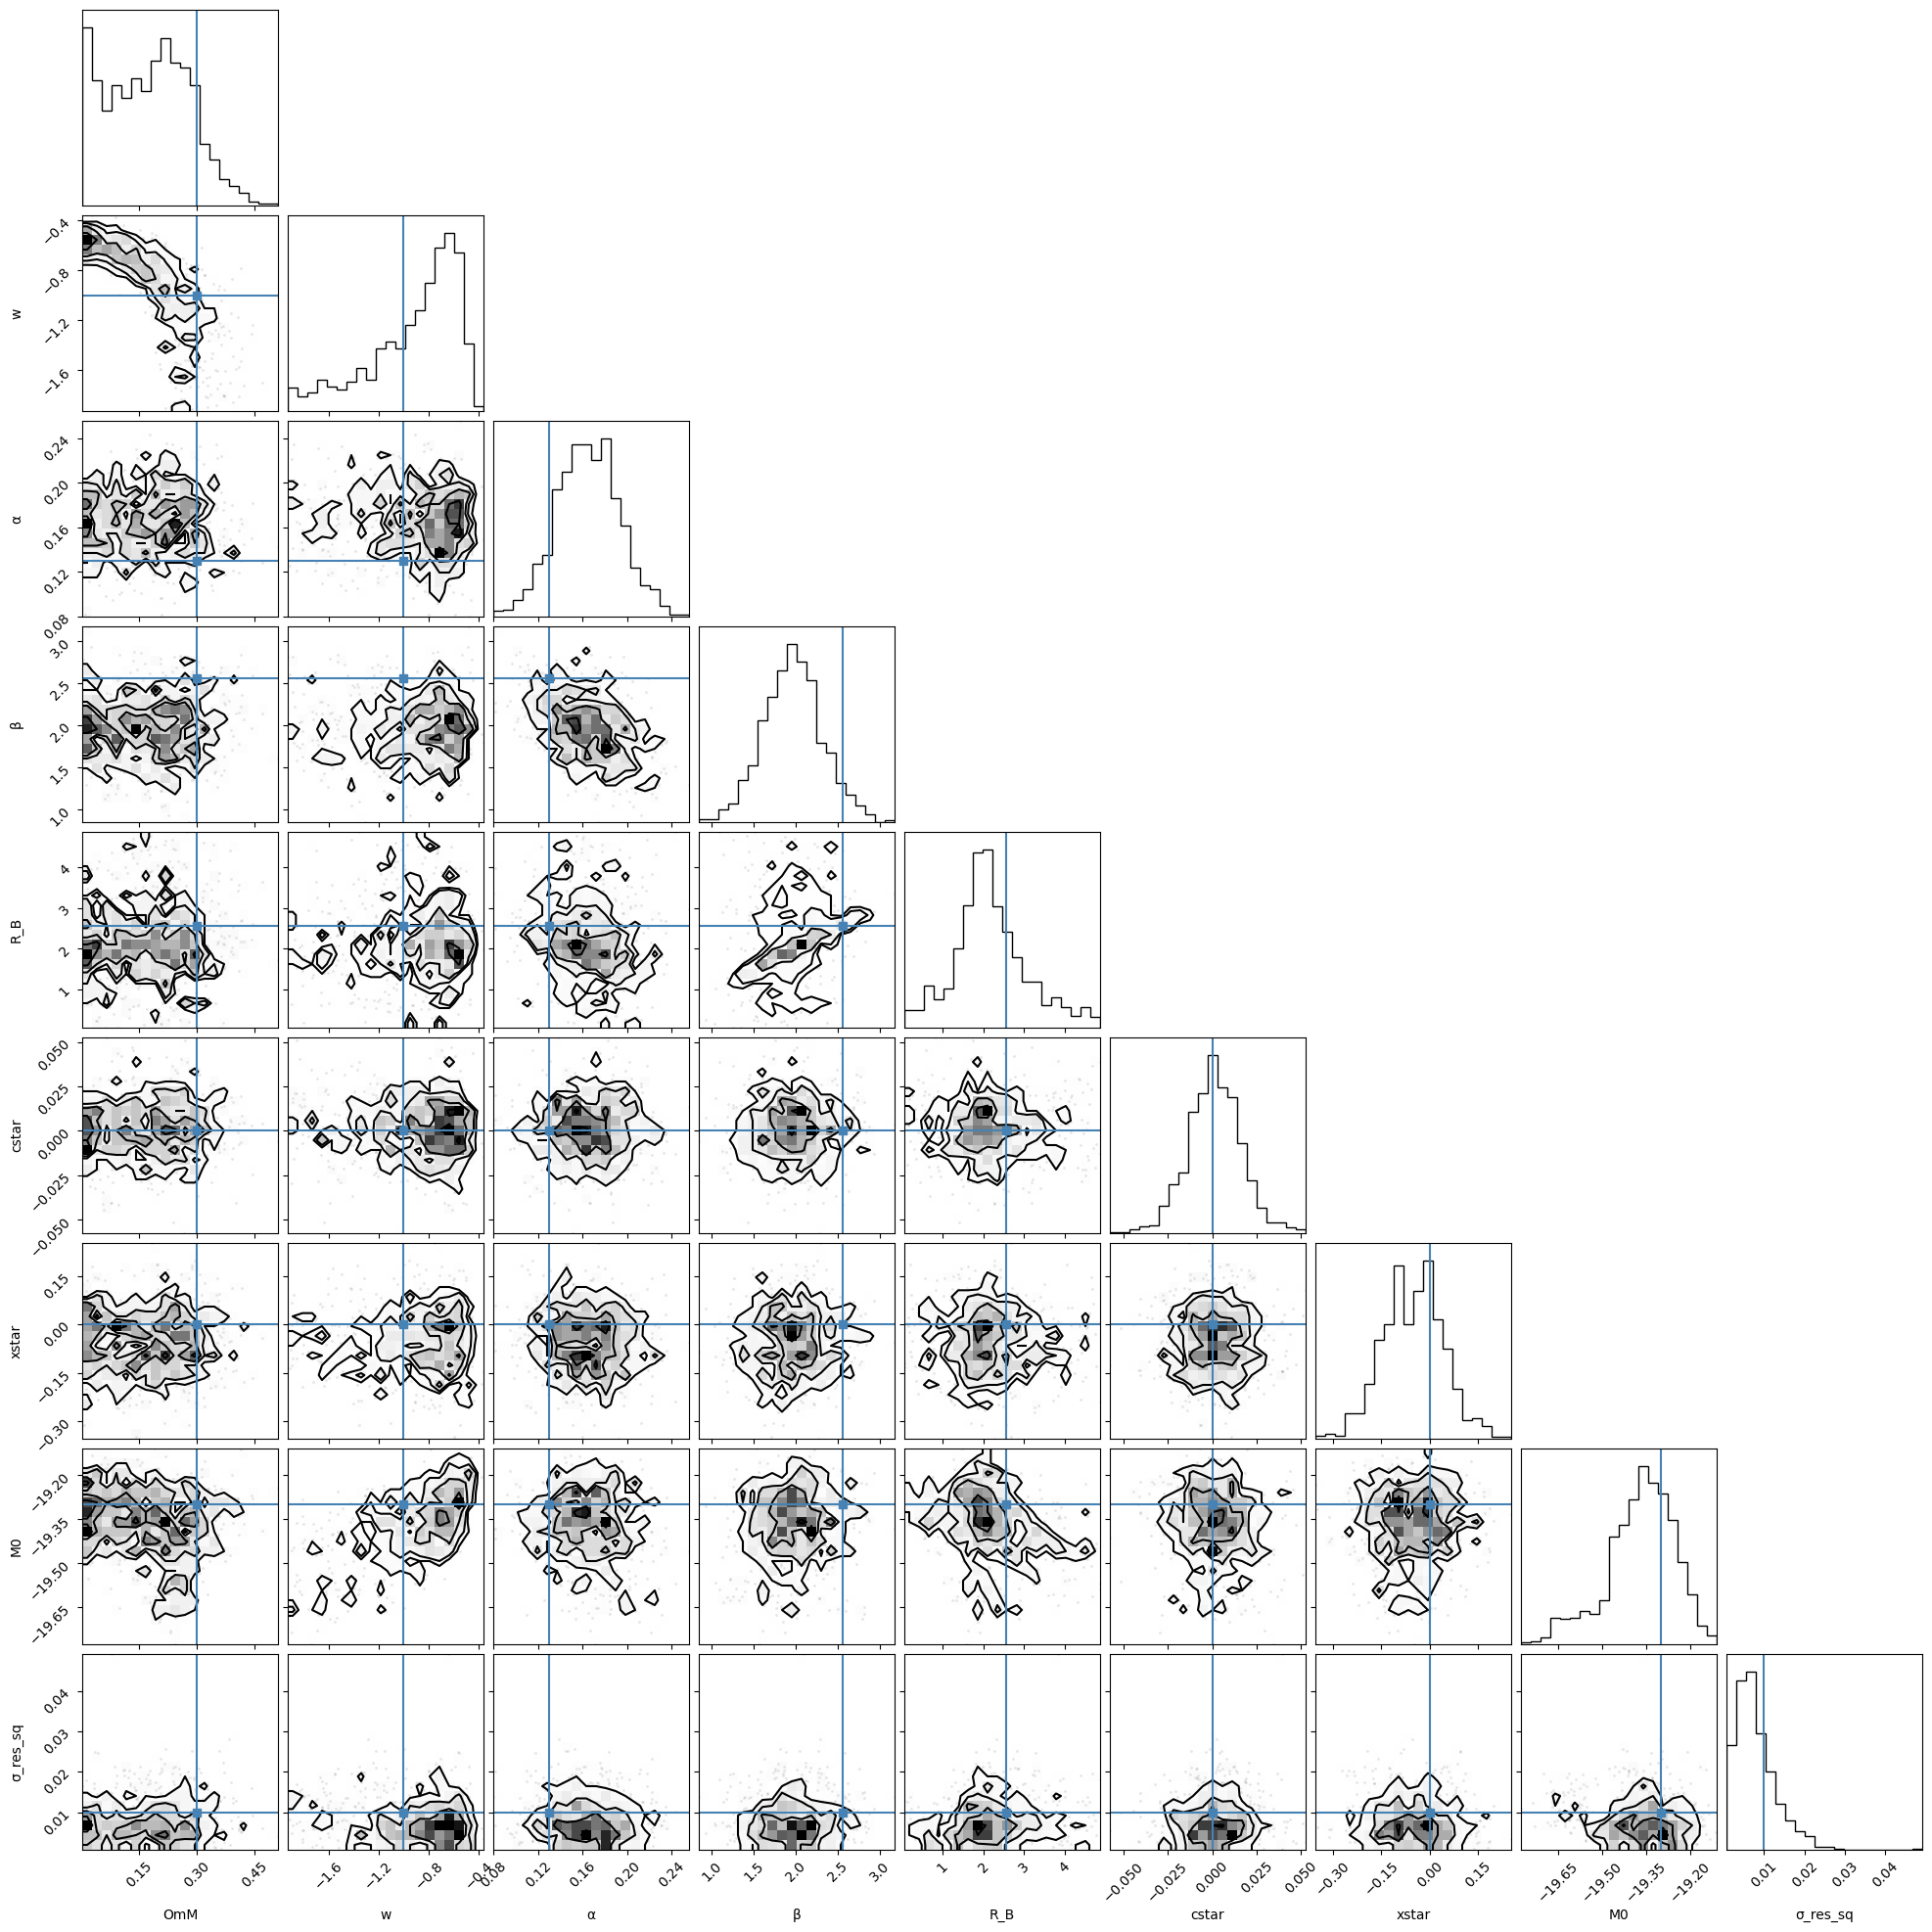

In [24]:
import corner

samples = mcmc.get_samples()
labels = ['OmM', 'w', 'α', 'β', 'R_B', 'cstar', 'xstar', 'M0', 'σ_res_sq'] 

# here tau should be unconstrained, since R_B = β = 2.56. 
truths = [0.3, -1.0, 0.13, 2.56, 2.56, 0.0, 0.0, -19.3, 0.1**2]

#omM, omDE = samples['cosmo'].T

flat_samples = onp.stack([samples[lab] for lab in labels]).T #np.stack(list([omM, omDE]), axis=1)
OmM_true, OmDE_true = 0.3, -1.0

fig = corner.corner(
    flat_samples, labels=labels, truths=truths
);

In [24]:
0.1**2

0.010000000000000002

# check model latents
Now that we've run our inference, we can take a look at how our model did. First compare latents to plug-in estimates for various quantities

In [25]:
datafname = 'lc_params.txt'

# load data 

names = ['z', 'c', 'x1', 'mb']
datadf = pd.read_csv(datafname, header=0, sep='\s+', usecols=names)
z = datadf['z'].values

# unpack block diags
sigmaC = onp.array(onp.loadtxt('sim_statssys.txt'))
M = int(3)
covs = np.array([sigmaC[i*M:(i+1)*M,i*M:(i+1)*M] for i in range(sigmaC.shape[0]//M)])

# compute mus for each SN
_OmM = np.mean(samples['OmM'])
_w = np.mean(samples['w'])
_beta = np.mean(samples['β'])
_alpha = np.mean(samples['α'])

_mus = muz(_OmM, _w, z) - _alpha*datadf['x1'].values + _beta*datadf['c'].values

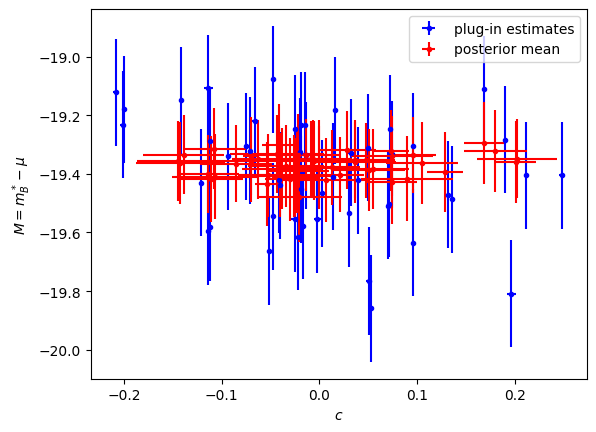

In [26]:
cobserr = [covs[i][0, 0] for i in range(len(covs))]
plt.errorbar(datadf['c'],
             datadf['mb'] - _mus,
             yerr = np.std(datadf['mb'].values - _mus, axis=0),fmt='.',
             xerr = cobserr, c='b', label='plug-in estimates')

plt.errorbar(np.mean(samples['c'], axis=0),
             np.mean(samples['M'], axis=0),
             yerr = np.std(samples['M'], axis=0),fmt='.',
             xerr = np.std(samples['c'], axis=0), c='r', label='posterior mean')

plt.ylabel(r"$M = m^*_B - \mu$")
plt.xlabel(r'$c$')
plt.legend()

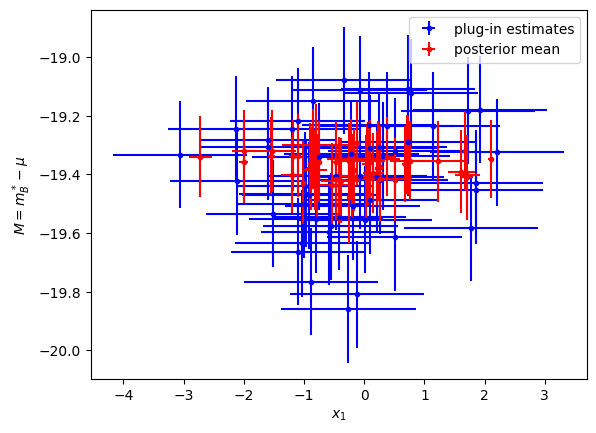

In [27]:
x1obserr = [covs[i][1, 1] for i in range(len(covs))]
plt.errorbar(datadf['x1'],
             datadf['mb'] - _mus,
             yerr = np.std(datadf['mb'].values - _mus, axis=0), fmt='.',
             xerr = np.std(datadf['x1'].values, axis=0), c='b', label='plug-in estimates')

plt.errorbar(np.mean(samples['x1'], axis=0),
             np.mean(samples['M'], axis=0),
             yerr = np.std(samples['M'], axis=0), fmt='.',
             xerr = x1obserr, c='r', label='posterior mean')

plt.ylabel(r"$M = m^*_B - \mu$")
plt.xlabel(r'$x_1$')
plt.legend()

We observe that using the posterior mean of latents for residual $M_i$ calculation reduces spread with respect to $c$ and $x_1$ light curve parameters.

# the money plot
Isolate the corner for $\Omega_m$-$w$ inference

In [ ]:
np.save('bhm_samples_ndata_500', flat_samples)

In [ ]:
data.shape

(500, 3)

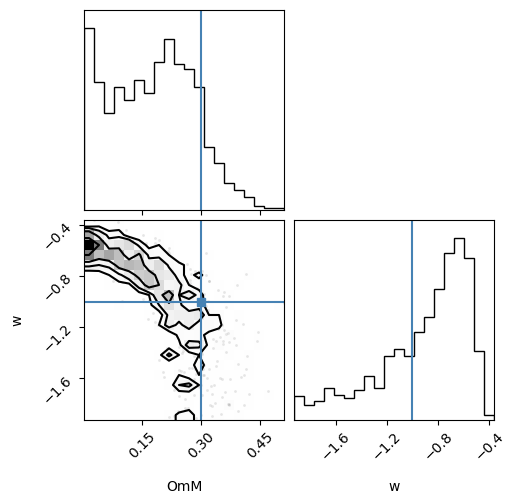

In [28]:
samples = mcmc.get_samples()
labels = ['OmM', 'w'] #list(samples.keys())

truths = [0.3, -1.0]

#omM, omDE = samples['cosmo'].T

flat_samples = onp.stack([samples[lab] for lab in labels]).T #np.stack(list([omM, omDE]), axis=1)
OmM_true, OmDE_true = 0.3, -1.0

fig = corner.corner(
    flat_samples, labels=labels, truths=truths
);